# Start up

In [1]:
# load packages
import ixmp                    # package for ix modeling platform
import message_ix              # package for MESSAGEix model
import pandas as pd
import re
import matplotlib.pyplot as plt
from message_ix.utils import make_df
from filter_plot import *      #import two functions to plot scenario outcomes

ValueError: The order of the files do not match. (expected: emissions/emissions.txt, found C:\Users\maximiko\Anaconda3\envs\message_env\Lib\site-packages\iam_units\data\emissions\emissions.txt)

In [2]:
# Loading the platform (and getting conected to a local database)
mp = ixmp.Platform()

# Base scenario

In [3]:
# create empty scenario
baseline = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario='baseline', version='new')

In [4]:
# read South Africa model from Excel (init_items = True is important as this scenario also includes MACRO)
baseline.read_excel("MESSAGEix_South_Africa.xlsx", add_units=True, commit_steps=False, init_items=True)

In [5]:
# solve baseline scenario
baseline.solve()

In [6]:
# check objective function value
baseline.var('OBJ')

{'lvl': 63014.5703125, 'mrg': 0.0}

In [7]:
#check the setup of dataframes of MESSAGEix variables
for i in baseline.var_list():
    if i != 'OBJ':
        df = baseline.var(i)
        print(df.columns.values.tolist(), '-->', i)

['node', 'commodity', 'grade', 'year', 'lvl', 'mrg'] --> EXT
['node', 'commodity', 'level', 'year', 'lvl', 'mrg'] --> STOCK
['node_loc', 'technology', 'year_vtg', 'lvl', 'mrg'] --> CAP_NEW
['node_loc', 'technology', 'year_vtg', 'year_act', 'lvl', 'mrg'] --> CAP
['node_loc', 'technology', 'year_vtg', 'year_act', 'mode', 'time', 'lvl', 'mrg'] --> ACT
['node', 'emission', 'type_tec', 'year', 'lvl', 'mrg'] --> EMISS
['node', 'land_scenario', 'year', 'lvl', 'mrg'] --> LAND
['relation', 'node_rel', 'year_rel', 'lvl', 'mrg'] --> REL
['node', 'commodity', 'level', 'year', 'time', 'lvl', 'mrg'] --> DEMAND
['node', 'commodity', 'level', 'year', 'time', 'lvl', 'mrg'] --> PRICE_COMMODITY
['node', 'type_emission', 'type_tec', 'year', 'lvl', 'mrg'] --> PRICE_EMISSION
['node', 'year', 'lvl', 'mrg'] --> COST_NODAL
['node', 'year', 'lvl', 'mrg'] --> COST_NODAL_NET
['node', 'year', 'lvl', 'mrg'] --> GDP
['node', 'year', 'lvl', 'mrg'] --> I
['node', 'year', 'lvl', 'mrg'] --> C


In [8]:
#check the setup of dataframes of MESSAGEix parameters
for i in baseline.par_list():
    df = baseline.par(i)
    print(df.columns.values.tolist(), '-->', i)

['node', 'commodity', 'level', 'year', 'value', 'unit'] --> commodity_stock
['node', 'commodity', 'level', 'year', 'time', 'value', 'unit'] --> demand
['node', 'commodity', 'grade', 'year', 'value', 'unit'] --> resource_cost
['node', 'commodity', 'grade', 'year', 'value', 'unit'] --> resource_remaining
['node', 'commodity', 'grade', 'year', 'value', 'unit'] --> bound_extraction_up
['node', 'commodity', 'grade', 'value', 'unit'] --> resource_volume
['node_loc', 'technology', 'year_vtg', 'value', 'unit'] --> technical_lifetime
['node_loc', 'technology', 'year_vtg', 'year_act', 'time', 'value', 'unit'] --> capacity_factor
['node_loc', 'technology', 'year_vtg', 'year_act', 'value', 'unit'] --> operation_factor
['node_loc', 'technology', 'year_vtg', 'year_act', 'value', 'unit'] --> min_utilization_factor
['node_loc', 'technology', 'year_vtg', 'value', 'unit'] --> inv_cost
['node_loc', 'technology', 'year_vtg', 'year_act', 'value', 'unit'] --> fix_cost
['node_loc', 'technology', 'year_vtg', 

In [9]:
# function to create list that filters for unique technology/commodity names
# var is MESSAGE variable, e.g. 'ACT'
# col is the to be chosen column, e.g. 'technology'
# group is the prefix or suffix to be filtered for, e.g. '_extr'. If pre- or suffix depends on 'typ' setting. IF set to zero, then no pre-/suffix
# typ is the switch for going for pre- or suffix; prefix for typ = 0
def filter_var(var,col,group,typ):
    mylist = baseline.var(var)[col].unique().tolist()
    if group == 0 and typ == 0:
        newlist = mylist
    elif typ == 0:
        r = re.compile("{}.*".format(group))
        newlist = list(filter(r.match, mylist))
    else:
        r = re.compile(".*{}".format(group))
        newlist = list(filter(r.match, mylist))
    return newlist

# function to plot 'lvl' and 'mrg' of the selected MESSAGE variable, grouped by year (of activity/demand/...); vintage years are grouped together
# scenario is the chosen scenario
# var is MESSAGE variable, e.g. 'ACT'
# col is the to be chosen column, e.g. 'technology'
# ls is a list of unique technology/commodity names, resulting from the 'filter_var' function
def plot_var(scenario,var,col,ls):
    df = scenario.var(var)
    if var == 'ACT' or var == 'CAP':
        year = 'year_act'
    elif var == 'CAP_NEW':
        year == 'year_vtg'
    else:
        year = 'year'
    fig, (ax1,ax2) = plt.subplots(1,2)
    if col == 0 and ls == 0:
        if var == 'EMISS':#emissions of ZA and the world are the same, therfore this work-around works
            df.groupby([year, 'emission']).sum()['lvl'].unstack().plot.bar(ax=ax1, figsize=(15, 5), legend=False)
            df.groupby([year, 'emission']).sum()['mrg'].unstack().plot.bar(ax=ax2).legend(loc='best')
        else:
            df.groupby([year, 'node']).sum()['lvl'].unstack().plot.bar(ax=ax1, figsize=(15, 5), legend=False)
            df.groupby([year, 'node']).sum()['mrg'].unstack().plot.bar(ax=ax2).legend(loc='best')
    else:
        df = df.loc[df[col].isin(ls)]
        df.groupby([year, col]).sum()['lvl'].unstack().plot.bar(ax=ax1, figsize=(15, 5), legend=False)
        df.groupby([year, col]).sum()['mrg'].unstack().plot.bar(ax=ax2).legend(loc='best')
    plt.subplots_adjust(wspace=0.50)
    ax1.set_title('lvl of selected variable',size=10)
    ax2.set_title('mrg of selected variable',size=10)
    
    
######
#Both of these functions are packed into a python fle and called from there then into the other notebooks. IT only stays here to show it and to experiment with it
######

In [17]:
# enable inline plots
%matplotlib inline

In [ ]:
# check objective function value
baseline.var('OBJ')

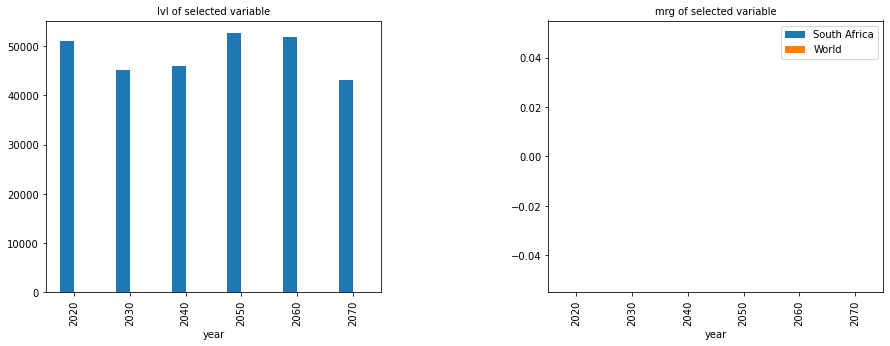

In [18]:
# plot the costs over the time horizon
plot_var(baseline,'COST_NODAL',col=0,ls=0)

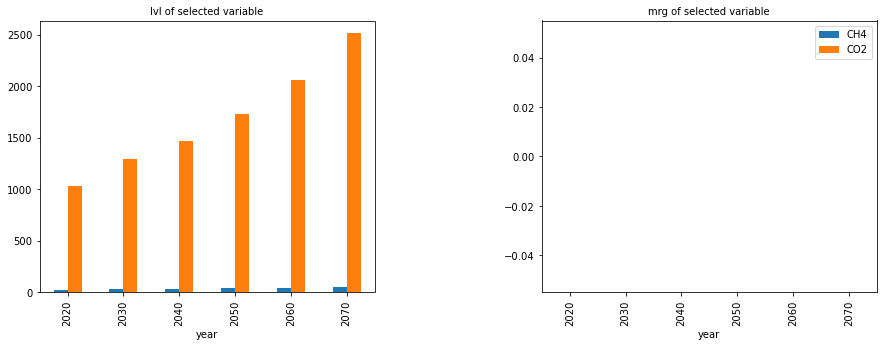

In [19]:
# plot the emissions over the time horizon
plot_var(baseline,'EMISS',col=0,ls=0)

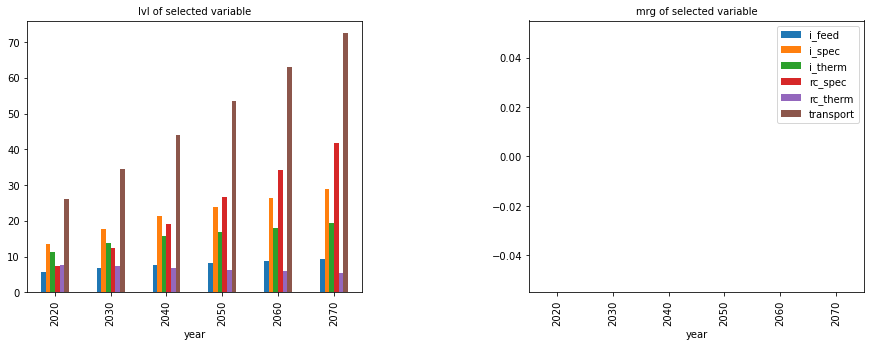

In [20]:
# plot the commodity demand over the time horizon
ls = filter_var('DEMAND','commodity',group=0,typ=0)
plot_var(baseline,'DEMAND','commodity',ls)

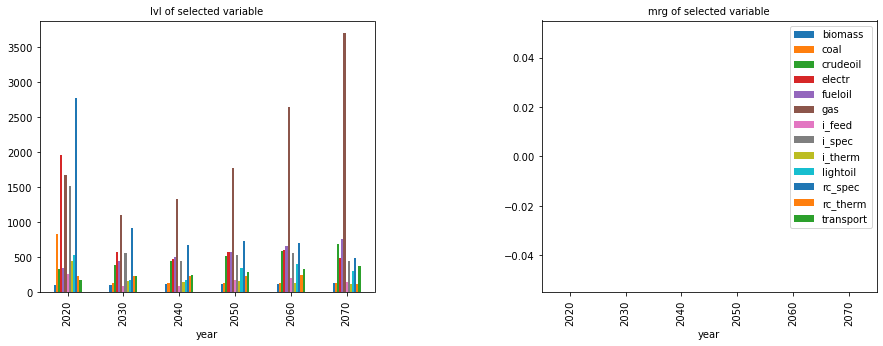

In [21]:
# plot the commodity prices over the time horizon
ls = filter_var('PRICE_COMMODITY','commodity',group=0,typ=0)
plot_var(baseline,'PRICE_COMMODITY','commodity',ls)

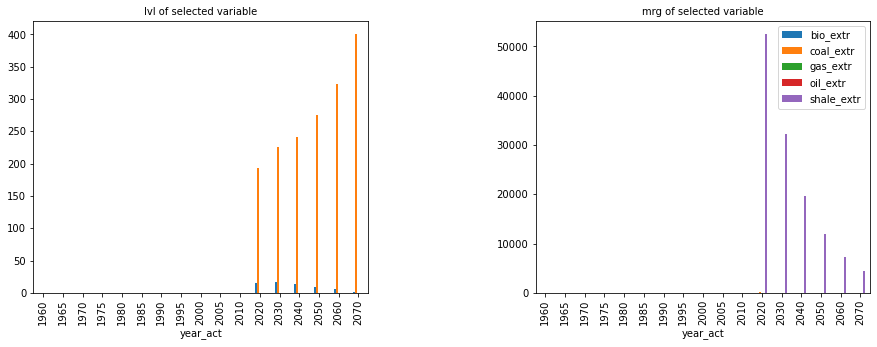

In [22]:
# plot extractive technology activity levels over the time horizon
ls = filter_var('ACT','technology',group='_extr',typ=1)
plot_var(baseline,'ACT','technology',ls)

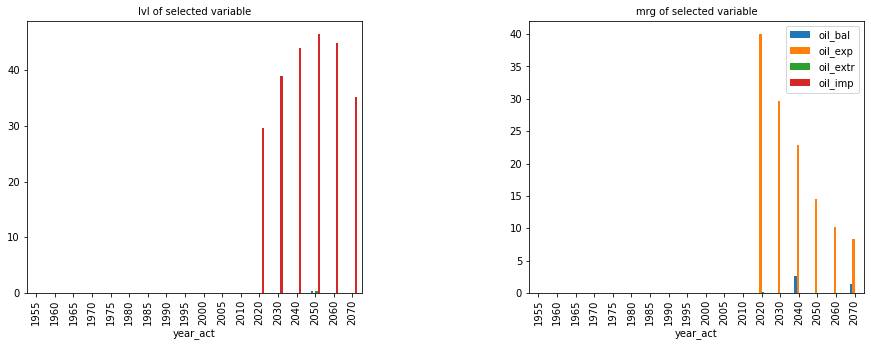

In [23]:
# plot activity levels of oil technologies over the time horizon
ls = filter_var('ACT','technology',group='oil_',typ=0)
plot_var(baseline,'ACT','technology',ls)

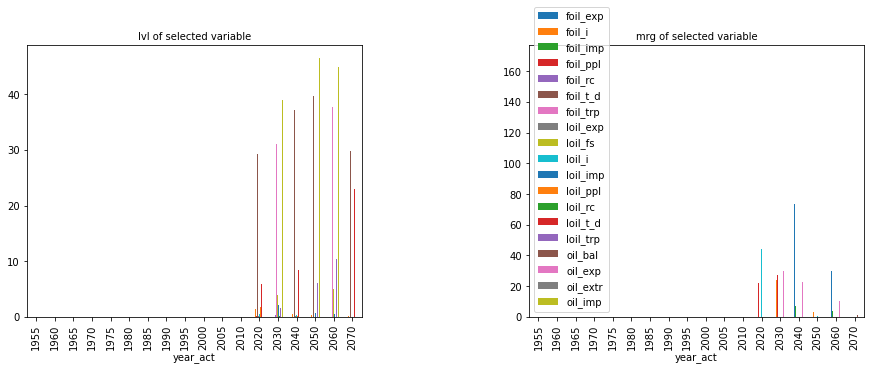

In [24]:
# plot activity levels of oil technologies over the time horizon
ls = filter_var('ACT','technology',group='oil',typ=1)
plot_var(baseline,'ACT','technology',ls)

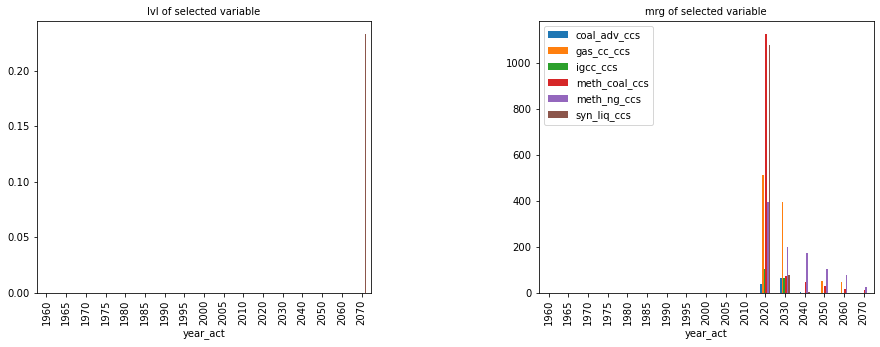

In [25]:
# plot activity levels of ccs technologies over the time horizon
ls = filter_var('ACT','technology',group='_ccs',typ=1)
plot_var(baseline,'ACT','technology',ls)

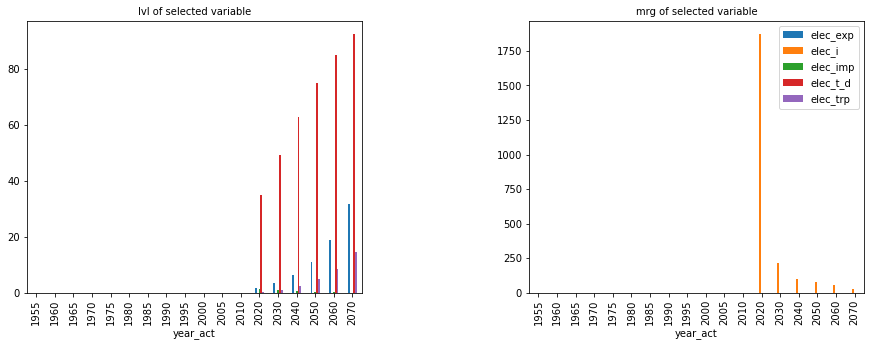

In [26]:
# plot activity levels of electricity demanding technologies over the time horizon
ls = filter_var('ACT','technology',group='elec',typ=1)
plot_var(baseline,'ACT','technology',ls)

In [ ]:
# plot activity levels of transport technologies over the time horizon
ls = filter_var('ACT','technology',group='_trp',typ=1)
plot_var(baseline,'ACT','technology',ls)

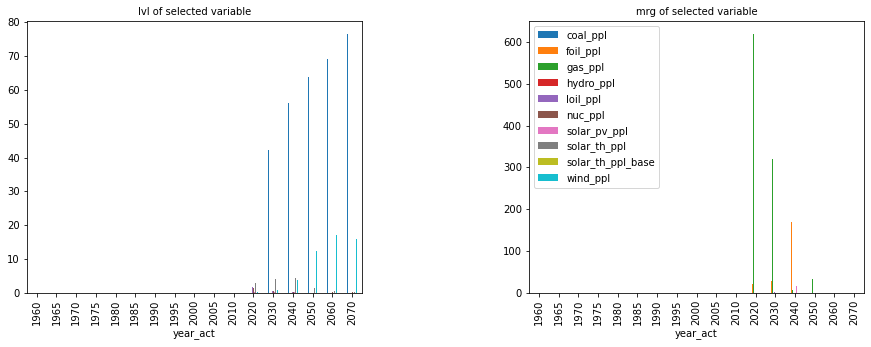

In [27]:
# plot activity levels of powerplants over the time horizon
ls = filter_var('ACT','technology',group='_ppl',typ=1)
plot_var(baseline,'ACT','technology',ls)

In [ ]:
# plot capacity levels of powerplants over the time horizon
ls = filter_var('CAP','technology',group='_ppl',typ=1)
plot_var(baseline,'CAP','technology',ls)

In [ ]:
# close platform connection
mp.close_db()